Ta# sk 1: Exploratory Data Analysis and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import os 
import sys
sys.path.append(os.path.abspath("../src"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %%
os.chdir("..")  # Go up a directory
#print(os.getcwd())

Perform Initial EDA

In [4]:
from EDA_Preprocessing import load_data
df = load_data("Data/complaints.csv")

Error loading file: Unable to allocate 1.15 GiB for an array with shape (16, 9609797) and data type object


In [ ]:
import pandas as pd
import gc

In [13]:
df = display_csv_chunks("Data/complaints.csv", chunksize=100_000, max_chunks=1)

# Now you can work with df
print("\n✅ Shape of returned DataFrame:", df.shape)


🔹 Chunk 1 - First 5 Rows:
  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt not owed   
2         Credit reporting           Improper use of your report   
3         Credit reporting           Improper use of your report   
4         Credit reporting  Incorrect information on your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else              

In [15]:
df.head()
df.shape

(100000, 18)

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                

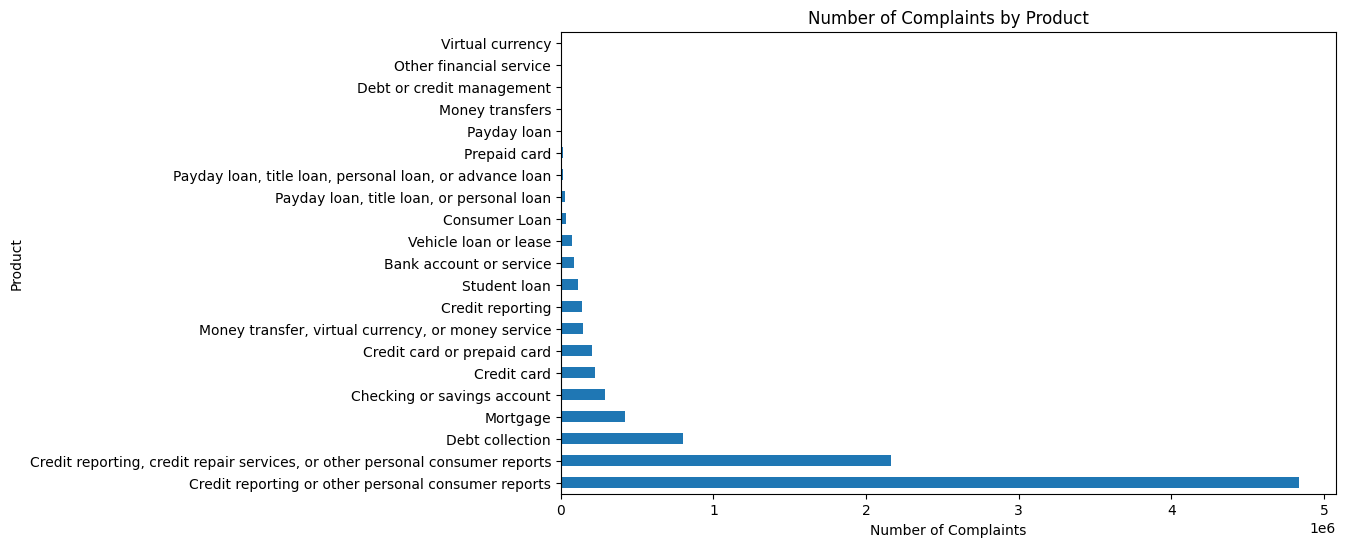

In [4]:
# Show basic structure
print(df.columns)
print(df.dtypes)
print(df.isna().sum())

# Distribution of complaints by Product
plt.figure(figsize=(10, 6))
df['Product'].value_counts().plot(kind='barh')
plt.title('Number of Complaints by Product')
plt.xlabel('Number of Complaints')
plt.show()

Analyze Complaint Narrative Length

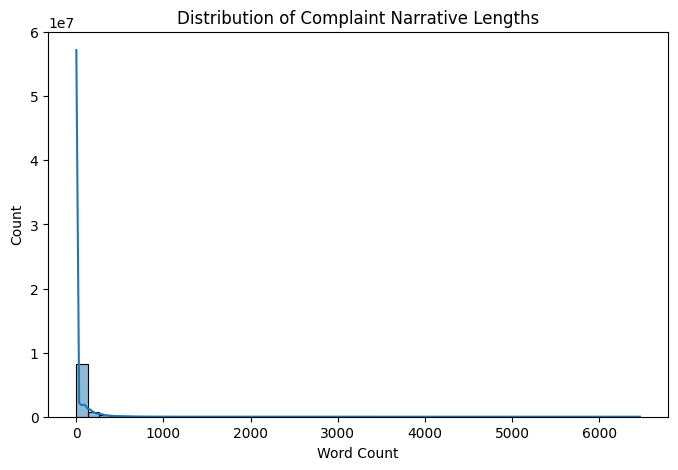

 Very short narratives (<10 words): 6650979
 Very long narratives (>500 words): 160989


In [5]:
df['narrative_length'] = df['Consumer complaint narrative'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['narrative_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Word Count')
plt.show()

# Short and long narratives
print(" Very short narratives (<10 words):", (df['narrative_length'] < 10).sum())
print(" Very long narratives (>500 words):", (df['narrative_length'] > 500).sum())

Count Complaints With vs Without Narrative

In [6]:
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = df['Consumer complaint narrative'].isna().sum()

print(f" Complaints with narratives: {with_narrative}")
print(f" Complaints without narratives: {without_narrative}")

 Complaints with narratives: 2980756
 Complaints without narratives: 6629041


Filter Dataset for Specified Products & Clean Narratives

In [7]:
TARGET_PRODUCTS = [
    "Credit card", 
    "Personal loan", 
    "Buy Now, Pay Later (BNPL)", 
    "Savings account", 
    "Money transfer, virtual currency, or money service"
]

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\bi am writing.*?complaint\b', '', text)  # remove boilerplate
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # normalize whitespace
    return text.strip()

def filter_and_clean(df):
    filtered = df[df['Product'].isin(TARGET_PRODUCTS)].copy()
    filtered = filtered[filtered['Consumer complaint narrative'].notna()]
    filtered['cleaned_narrative'] = filtered['Consumer complaint narrative'].apply(clean_text)
    return filtered

filtered_df = filter_and_clean(df)
print(f"Filtered data shape: {filtered_df.shape}")

Filtered data shape: (177855, 20)


Save Cleaned Dataset

In [8]:
def save_filtered_data(df, path="Data/filtered_complaints.csv"):
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        df.to_csv(path, index=False)
        print(f" Filtered dataset saved to {path}")
    except Exception as e:
        print(f" Failed to save file: {e}")

save_filtered_data(filtered_df)

 Filtered dataset saved to Data/filtered_complaints.csv


In [7]:
df_clean = pd.read_csv("Data/filtered_complaints.csv")
df_clean.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_length,cleaned_narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91,a xxxx xxxx card was opened under my name by a...
1,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156,dear cfpb i have a secured credit card with ci...
2,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233,i have a citi rewards cards the credit balance...
3,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454,bi am writing to dispute the following charges...
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"Although the account had been deemed closed, I...",Company believes it acted appropriately as aut...,Atlanticus Services Corporation,NY,11212,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13965746,170,although the account had been deemed closed i ...


In [8]:
df_clean.shape

(177855, 20)